<a href="https://colab.research.google.com/github/ankush2805/EIP/blob/master/Assignment%204/Assignment%204B/Assignment%204B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
batch_size= 32
epochs = 50

num_classes = 10
num_filters = 64
blocks_size = 4
sub_blocks_size = 2

In [35]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]
print(input_shape)

(32, 32, 3)


In [36]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=7,
           padding='same',
           strides=2,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)


for i in range(blocks_size):
    for j in range(sub_blocks_size):
        strides = 1
        if j == 0 and i > 0:
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if j == 0 and i > 0:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [39]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'resnet_cifar10_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))

datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/50
1562/1562 [==============================] - 60s 39ms/step - loss: 2.3299 - acc: 0.4082 - val_loss: 2.2875 - val_acc: 0.3647

Epoch 00001: val_loss improved from inf to 2.28746, saving model to /content/saved_models/resnet_cifar10_model.h5
Epoch 2/50
1562/1562 [==============================] - 55s 35ms/step - loss: 1.7193 - acc: 0.5363 - val_loss: 1.6876 - val_acc: 0.5364

Epoch 00002: val_loss improved from 2.28746 to 1.68756, saving model to /content/saved_models/resnet_cifar10_model.h5
Epoch 3/50
1562/1562 [==============================] - 56s 36ms/step - loss: 1.5010 - acc: 0.6008 - val_loss: 1.5161 - val_acc: 0.6074

Epoch 00003: val_loss improved from 1.68756 to 1.51612, saving model to /content/saved_models/resnet_cifar10_model.h5
Epoch 4/50
1562/1562 [==============================] - 55s 35ms/step - loss: 1.3779 - acc: 0.6413 - val_loss: 1.5169 - val_acc: 0.6110

Epoch 00004: val_loss did not improve from 1.51612
Epoch 5/50
1562/

In [0]:
(x_train1, y_train1), (x_test1, y_test1) = cifar10.load_data()

In [0]:
%matplotlib inline
from keras import backend as k
import cv2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

def plot_images(num_rows, num_cols):
  f, axarr = plt.subplots(num_rows, num_cols*2)
  for v in range(num_rows*num_cols):
    input_image = x_train1[v];
    input_image1 = x_train1[v];
    input_image = input_image.astype('float32') / 255
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)
    class_idx = np.argmax(preds[0])
    #print(class_idx)
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("activation_52")
    from keras import backend as K
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([input_image])

    for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (input_image1.shape[1], input_image1.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #print(input_image1.shape)
    superimposed_img = cv2.addWeighted(input_image1, 0.5, heatmap, 0.5, 0)
    axarr[int(v/num_cols),2*(v%num_cols)].imshow(input_image1)
    axarr[int(v/num_cols),2*(v%num_cols)+1].imshow(superimposed_img)

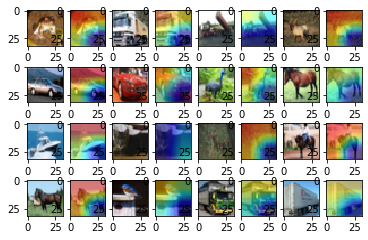

In [42]:
plot_images(4,4)